In [1]:
import numpy as np
import scipy.spatial.distance as distance
import scipy.stats as stats
import matplotlib.pyplot as plt
import keras as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from keras.datasets import mnist

In [3]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.initializers import RandomNormal

In [4]:
(x_train_f, y_train_f), (x_test, y_test) = mnist.load_data()

num_samples = x_train_f.shape[0]
num_val = 10000
num_train = num_samples - num_val

orig_dim = x_train_f.shape[1:] #useful for restoring original images
flat_dim = orig_dim[0] * orig_dim[1] #input dimension

shuffle_idx = np.random.permutation(num_samples)
x_val = np.round(x_train_f[shuffle_idx[:num_val]].copy().reshape(-1,flat_dim) / 255)
y_val = y_train_f[shuffle_idx[:num_val]].copy()
x_train = np.round(x_train_f[shuffle_idx[num_val:]].copy().reshape(-1,flat_dim) / 255)
y_train = y_train_f[shuffle_idx[num_val:]].copy()

In [5]:
class encoder_network():
    def __init__(self,sess,n_parts, input_dim, output_dim, n_hidden =400, mu = 0, sigma = 1):
        self.n_parts = n_parts
        self.n_hidden = n_hidden
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.mu = mu
        self.sigma = sigma
        
        self.sess = sess
        
        self.model = self.build_network()
        self.eta_grad = self.build_grad()
    
        self.sess.run(tf.global_variables_initializer())
        
    def build_network(self):
        encoder_inputs = Input(batch_shape=(None,self.input_dim,))
        encoder_hidden = Dense(self.n_hidden, activation='tanh',
                       kernel_initializer = RandomNormal(self.mu,self.sigma),
                               bias_initializer = RandomNormal(self.mu,self.sigma))(encoder_inputs)
        encoder_output = Dense(self.output_dim,#activation='sigmoid',
                       kernel_initializer = RandomNormal(self.mu,self.sigma),
                               bias_initializer = RandomNormal(self.mu,self.sigma))(encoder_hidden)
        encoder = Model(inputs = encoder_inputs, outputs = encoder_output)
        
        return encoder
    
    def build_grad(self):
        grads = []
        for eta in self.model.trainable_weights:
            a = []
            for i in range(self.n_parts):
                b = []
                for j in range(self.output_dim):
                    b.append(tf.gradients(self.model.output[i,j],eta))
                a.append(b)
            grads.append(a)
        return grads
            
    def eval_eta_grad(self,x_in):
        return self.sess.run(self.eta_grad, feed_dict={self.model.input : x_in})

In [6]:
class decoder_network():
    def __init__(self,sess,n_parts,input_dim,output_dim,n_hidden = 400, mu = 0, sigma = 1):
        self.n_parts = n_parts
        self.n_hidden = n_hidden
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.mu = mu
        self.sigma = sigma
        
        self.sess = sess
        
        self.model = self.build_network()
        
        self.x_real = tf.placeholder(tf.float32, shape=(self.output_dim,))
        self.logpxz = self.eval_logpxz(self.x_real, self.model.output)
        
        self.theta_grad = tf.gradients(self.logpxz, self.model.trainable_weights)
        self.z_grad = tf.gradients(self.logpxz, self.model.input)
        
        self.sess.run(tf.global_variables_initializer())
        
    def build_network(self):
        decoder_inputs = Input(batch_shape=(None, self.input_dim))
        decoder_hidden = Dense(self.n_hidden,activation='tanh',
                               kernel_initializer = RandomNormal(self.mu,self.sigma),
                               bias_initializer = RandomNormal(self.mu,self.sigma))(decoder_inputs)
        decoder_output = Dense(self.output_dim, activation='sigmoid',
                               kernel_initializer = RandomNormal(self.mu,self.sigma),
                               bias_initializer = RandomNormal(self.mu,self.sigma))(decoder_hidden)
        decoder = Model(inputs = decoder_inputs, outputs = decoder_output)
        return decoder
    
    # grad with respect to theta of log p(x|z)
    def eval_theta_grad(self,z,x_in):
        return self.sess.run(self.theta_grad,feed_dict={self.model.input:z, self.x_real:x_in})
    
    # grad with respect to z of log p(x|z)
    def eval_z_grad(self,z,x_in):
        return self.sess.run(self.z_grad,feed_dict={self.model.input:z, self.x_real:x_in})
    
    def eval_logpxz(self, x_real, x_rec):
        x_real = tf.reshape(x_real,(1,self.output_dim))
        X_real = tf.tile(x_real,(self.n_parts,1))
        x_rec  = tf.reshape(x_rec,(self.n_parts,self.output_dim))
        
        fudge = 1e-15
        
        part1 = X_real * tf.log(x_rec + fudge)
        part2 = (1-X_real) * tf.log(1-x_rec + fudge)
        
        logpxz = tf.reduce_sum(tf.where(X_real==1, part1, part2), axis=1)
        
        return logpxz

In [7]:
def rbf_kernel(x,h = -1):
        dist_mat = distance.squareform(distance.pdist(x)) **2 #use scipy package to calculate pairwise euclidean distance mat

        if h < 0 : #as suggested in the paper, calculate bandwith like so
            h = np.sqrt(0.5*np.median(dist_mat) / np.log(x.shape[0]+1))

        kxy = np.exp(-dist_mat / h**2 /2) #rbf kernel formula

        dkxy = -np.matmul(kxy , x) #first part of derivative of kxy
        for i in range(x.shape[1]): #second part of derivative of kxy
            dkxy[:,i] += x[:,i] * np.sum(kxy,axis=1)
        dkxy /= h**2
        return kxy, dkxy

In [8]:
def extend_input(x_input, loc, scale, n_parts):
    
    xsi = np.random.normal(loc,scale,size=(n_parts,1))
    x_extended = np.tile(x_input,(n_parts,1))
    
    assert np.shape(x_extended) == (n_parts, np.size(x_input))

    return np.hstack((x_extended,xsi))

In [9]:
batch_size = 1
iters = 1
n_parts = 50

epsilon = 1e-3

input_dim = flat_dim +1
latent_dim = 32
n_hidden = 400

loc = 0
scale = 1

In [ ]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

encoder = encoder_network(sess, n_parts, input_dim, latent_dim)
decoder = decoder_network(sess, n_parts, latent_dim, flat_dim)

for t in range(iters):
    x_input = extend_input(x_train[t],loc, scale, n_parts)

    z = encoder.model.predict(x_input,batch_size=n_parts)
   
    z_grad = decoder.eval_z_grad(z,x_train[t])
    z_grad = np.array(z_grad).reshape(n_parts,latent_dim)
        
    kzy, dkzy = rbf_kernel(z)
    phi = (kzy @ (z_grad - z) + dkzy) / n_parts
    
    eta_grad = encoder.eval_eta_grad(x_input)
    theta_grad = decoder.eval_theta_grad(z,x_train[t])
    
    eta_1 = []
    for i,eta in enumerate(encoder.model.get_weights()):
        a = np.array(eta_grad[i]).reshape(n_parts,latent_dim,-1)
        b = np.array([np.matmul(phi[j,:].reshape(1,latent_dim),a[j,:,:]) for j in range(n_parts)])
        
        eta_1.append(eta + epsilon * np.sum(b,axis=0).reshape(eta.shape))
    encoder.model.set_weights(eta_1)
        
    theta_1 = []
    for i,theta in enumerate(decoder.model.get_weights()):
        theta_1.append(theta + [(1/n_parts) * c for c in theta_grad[i]])
    decoder.model.set_weights(theta_1) 

In [196]:
z = encoder.model.predict(extend_input(x_train[0],loc, scale, n_parts))
x_rec = decoder.model.predict(z)

In [198]:
z

array([[-105.636734, -167.70512 ],
       [-105.670685, -167.72641 ],
       [-107.27295 , -169.04385 ],
       [-103.63212 , -164.25671 ],
       [-103.535286, -166.4652  ],
       [-104.16021 , -166.84062 ],
       [-104.0012  , -172.4416  ],
       [-107.24133 , -169.72041 ],
       [-107.08359 , -168.7988  ],
       [-106.50993 , -168.29836 ],
       [-104.58394 , -172.1125  ],
       [-107.361206, -169.2533  ],
       [-106.50129 , -168.29185 ],
       [-106.76161 , -168.49771 ],
       [-104.45932 , -167.01114 ],
       [-104.44052 , -172.20468 ],
       [-107.32366 , -169.57939 ],
       [-106.70454 , -170.28314 ],
       [-106.49428 , -170.47859 ],
       [-107.370316, -169.30583 ],
       [-106.99791 , -170.00095 ],
       [-103.4195  , -172.64142 ],
       [-107.32479 , -169.57689 ],
       [-107.10983 , -168.82768 ],
       [-104.90375 , -171.88371 ],
       [-107.372055, -169.32307 ],
       [-107.34802 , -169.51746 ],
       [-103.84361 , -166.65627 ],
       [-106.41113 ,

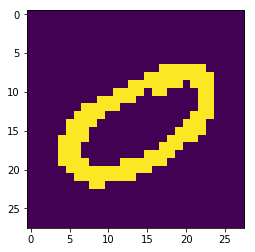

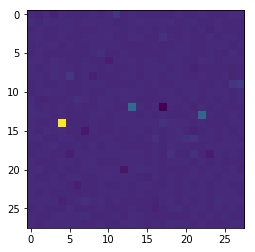

In [121]:
plt.imshow(x_train[0].reshape(28,28))
plt.show()
plt.imshow(x_rec[0,:].reshape(28,28))
plt.show()

In [ ]:
z_test = np.random.normal(size=[2,])
test_prediction = decoder.model.predict(z)